<a href="https://colab.research.google.com/github/simulate111/Deep-Learning-in-Human-Language-Technology/blob/main/Exercise%20task%203_hf_trainer_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, set up the required Python modules and perform some general configuration.

(This part of the code follows the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb) that you should already be familiar with.)

Install the required Python packages using [pip](https://en.wikipedia.org/wiki/Pip):

* [`transformers`](https://huggingface.co/docs/transformers/index) is a popular deep learning package
* [`datasets`](https://huggingface.co/docs/datasets/) provides support for loading, creating, and manipulating datasets
* [`evaluate`](https://huggingface.co/docs/evaluate/index) is a library for easily evaluating machine learning models and datasets
* [`accelerate`](https://pypi.org/project/accelerate/) is a wrapper we need to install in order to train torch models using a transformers trainer

Both `transformers` and `datasets` are used extensively on this course.

In [1]:
!pip3 install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


Comment:

Transformer is used to transfer pretrained model to the current NLP model to facilitates the computation.
Database is used to download the database and study on it like imdb.
evaluate will be used to evaluate th emodel.
accelerate will help to perform faster training and computation

(Above, the `!` at the start of the line tells the notebook to run the line as an operating system command rather than Python code, and the `-q` argument to `pip` runs the command in "quiet" mode, with less output.)

We'll also use the [`pprint`](https://docs.python.org/3/library/pprint.html) ("pretty-print") module to format output more readably below. The only difference to just using `print` is that some data structures will be easier to read and interpret.

In [2]:
from pprint import PrettyPrinter

pprint = PrettyPrinter(compact=True).pprint

Comment: prettyprinter facilitates displaying results in a better format.

Finally, we will reduce logging output. The `transformers` library by default produces fairly verbose logging. Commenting out the following code will enable low-priority output (`INFO` logging level and below).

In [3]:
import logging

logging.disable(logging.INFO)

Comment: Helpful for debugging, finding issues, and handling errors.

---

# Download and prepare data

We will again use the `datasets` library function [`load_dataset`](https://huggingface.co/docs/datasets/master/en/package_reference/loading_methods#datasets.load_dataset) to load a dataset for our experiments.

In [4]:
import datasets


dataset = datasets.load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Comment: Importing the desirable database for the study which is imdb here.

Let's see what the dataset contains:

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


and print out an example:

In [6]:
dataset = dataset.shuffle()
del dataset["unsupervised"]
pprint(dataset["train"][0])

{'label': 1,
 'text': 'The Thief of Baghdad is one of my ten all-time favorite movies. It '
         'is exciting without gore, it is beautifully filmed and the art '
         "direction is flawless. The casting couldn't have been better. Rex "
         'Ingram made me believe in genies. And the epitome of evil is '
         'certainly captured by Conrad Veight as Jafar. He set the bar very '
         'high.<br /><br />..I watch this movie at least twice a year...and '
         'never tire of it. This film is an adventure for all ages..no-one too '
         'old to enjoy it. The Thief of Bahgdad jogs my memories to a more '
         'innocent time...I was ten years old the first time I saw it and the '
         'U.S. was just about to enter WWII. Conrad Vieght was such a great '
         'actor that he was able to continue this underlying "evilness" a few '
         'years later in "Casablanca." And Korda teamed up,I believe, with '
         'Justin and Dupree again in "The Four Feathe

Comment: Shuffling the data to prevent any predefined order or being biased in training which gives better training and evaluation result

---

# Tokenize and vectorize data

(This part of the code follows the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb) that you should already be familiar with.)

To tokenize and vectorize the texts of our dataset, we will again use previously created tokenizers through the simple [`AutoTokenizer`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) class.

The [`AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer.from_pretrained) function can load the tokenizer associated with any of the large number of models found in the [Hugging Face models repository](https://huggingface.co/models). Here, our texts are in English, and we'll load the tokenizer for the [`bert-base-cased`](https://huggingface.co/bert-base-cased) model.

(**Note**: we're not actually using the BERT model here, just its tokenizer.)

In [7]:
import transformers

model_name = "bert-base-cased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Comment: bert model is imported through transformer and used for tokenization, and we do not need to make out model from the scratch.

As in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), we will define a simple tokenization function and tokenize and vectorize our whole dataset with the tokenizer by calling the [`Dataset.map`](https://huggingface.co/docs/datasets/v2.14.4/en/package_reference/main_classes#datasets.Dataset.map) function.

Note that here we're providing a `max_length` argument and `truncation=True` in the tokenizer call. This limits the maximum length of outputs to the given length (see the [tokenizers documentation](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) for details). This makes training faster, potentially at some cost in performance.

In [8]:
# Define a simple function that applies the tokenizer
def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=128,
        truncation=True,
    )

# Apply the tokenizer to the whole dataset using .map()
dataset = dataset.map(tokenize)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Comment: tokenizer function is defined to be abel to apply it on the dataset easilly using .map function. The toeknizer is limited to the token length of 128 to make trianng faster instead of considering longer tokens or sentence.

---

# Build model

As usual, we will create a PyTorch model class with an `__init__()` function that creates the layers and a `forward()` function which implements the actual computation. For more information on these, please see the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html).

We're here building a simple RNN with the following structure:

* As in the [CNN](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), the token IDs are first mapped to embeddings of a user-specified size (`config.embedding_dim`) in a [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer. Note that here the embeddings are initialized randomly and learned along with other model weights. In real-world applications, the embeddings would typically be initialized with previously learned weights.
* Second, the embedded inputs are passed through an RNN ([torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)), which produces a series of outputs ($(y_1, \ldots, y_n)$, where $n$ is the length of the input) and the final hidden state $h_n$. Here, we will only use the last output $y_n$.
* Finally, there is a fully connected layer ([torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) that maps the last RNN output to the two possible output values of the classifier.

We can interpret this model as processing the input step by step, attempting to identify tokens (embeddings) that in the context of its previous input express either positive or negative opinions, and to output a value at the end of the sequence that can be mapped to the positive or negative class.

In the `forward` function we mostly just pass the input through the layers, with the following additional steps:

* To invoke the RNN, we need to provide the value of the initial hidden state $h_0$. Here we simply use [torch.zeros](https://pytorch.org/docs/stable/generated/torch.zeros.html) to create a tensor of the appropriate size filled with zeros.
* To get the value of the last item in the sequence of RNN outputs (`rnn_outputs`), we slice the three-dimensional tensor (batch, rnn step, output dim) with `rnn_outputs[:, -1, :]`. This returns all values in the first and last dimensions, and the last in the second. If you are not familar with this syntax, consider the following example:

In [9]:
import numpy

a = numpy.array([
  [[11], [12], [13]],
  [[21], [22], [23]],
  [[31], [32], [33]],
])

print(a[:, -1, :])

[[13]
 [23]
 [33]]


Comment: Importing and using numpy library to make mathematical calculation and formla easier like using matrix and array of numpy.

(The two points above can be considered technical details and understanding them in detail is not required to understand the model.)

Here's the model:

In [10]:
import torch


# This gives a new name to the config class, just for convenience
BasicConfig = transformers.PretrainedConfig


# This is the model
class SimpleRNN(transformers.PreTrainedModel):

    config_class = BasicConfig

    # In the initialization method, one instantiates the layers
    # these will be the parameters of the model
    def __init__(self, config):
        super().__init__(config)
        # Embedding layer: vocab size x embedding dim
        self.embeddings = torch.nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.embedding_dim
        )
        # RNN with configurable hidden size and nonlinearity
        self.rnn = torch.nn.RNN(
            input_size=config.embedding_dim,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            nonlinearity=config.nonlinearity,
            batch_first=True
        )
        # Output layer: embedding size to output size
        self.output_layer = torch.nn.Linear(
            in_features=config.hidden_size,
            out_features=config.num_labels
        )
        # Loss function: standard loss for classification
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, labels=None, attention_mask=None):
        # Embed input ids
        x = self.embeddings(input_ids)
        # Set initial hidden state to all-zero values
        batch_size = x.shape[0]
        h0 = torch.zeros(
            (self.config.num_layers, batch_size, self.config.hidden_size),
            device=input_ids.device    # place on same device as input
        )
        # Run RNN repeatedly to get sequence of outputs and last hidden state
        rnn_outputs, h_n = self.rnn(x, h0)
        # Get last RNN output
        y_n = rnn_outputs[:, -1, :]
        # Map to outputs with fully connected layer
        output = self.output_layer(y_n)

        # Return value computed as in MLP and CNN:
        if labels is not None:
            # We have labels, so we can calculate the loss
            return (self.loss(output,labels), output)
        else:
            # No labels, so just return the output
            return (output,)

Comment:



*   pytorch library is used for deep learning model
*   transformers.PretrainedConfig : set some configurations of transformer model like hyperparameter, layer numbers, etc., which is used for Hugging Face library.
* SimpleRNN: we will define a class in python for our RNN model, which is isnpired by the model of transformers.PreTrainedModel.
* Then, the basic configuration is set for the model with BasicConfig command.
* To start the class functionality, __init__ function is used to automatiocally perform th ebasic operations like setting basic configuration here.
*  The embedding is configured at the next step with its dimension and required vocabulary size, where each vector represent a word.
* Now, RNN model will be defined here with self.rnn: the number of stacks, hidden layers, input size, with introducing the non linearity to the model and consider the first dimension as the batch size.
* To get output, a fully connected lyer is defined with self.output_layer to collect hidden layers and labels together.
* self.loss is used to calculate losses or errors in th emodel.
* The forward pass will be defined with def forward() funciton by first converting the input layer to the dense vector by embedding,
* The batch size is obtained from the first dimension with batch_size = x.shape[0] and then hidden state of h0 is set to zeros array.
* Extract the last output of batch. The last output will be become fully connected to achieve appropriate result.
* Finally, loss function is calculated to obtain error and evaluate th emodel.

---

# Configure and train model

We'll first configure and instantiate the model. Here `vocab_size` should always be the vocabulary size of the tokenizer and `num_labels` the number of unique labels in the data (as here), but the others are hyperparameters that you can choose:

* `embedding_dim`: the size of the word (i.e. token) embeddings
* `hidden_size`: the size of the RNN hidden state vector _h_
* `num_layers`: number of stacked RNN layers
* `nonlinearity`: the non-linear function to apply in RNN (`'tanh'` or `'relu'`)

In [11]:
config = BasicConfig(
    vocab_size = tokenizer.vocab_size,
    num_labels = len(set(dataset["train"]["label"])),
    embedding_dim = 64,
    hidden_size = 96,
    num_layers = 1,
    nonlinearity = "tanh",
)

model = SimpleRNN(config)

Comment: Required configurations are set here such as size of a vocabulary used by tokenizer. The name of labels which exist in the dataset. set function will remove duplicates. Then the dimension of embedding is defined to be 64. Hidden size is 96 in one layer. The non linearity of tanh is also introduced to the model. Finally, the configuration is assigned to the model.

Training arguments are set similarly as in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb). Many number of these settings relate to the frequency of evaluation and output during training, but the following are hyperparameters that you may wish to adjust:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per batch
* `max_steps`: the maximum number of steps to train for

In [12]:
# Set training arguments
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=500,
    logging_steps=500,
    learning_rate=0.001,
    per_device_train_batch_size=8,
    max_steps=2500,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Comment: Adopting from Hugging Face, it is possible to adjust model with some availabel parameters. checkpoint will save the model. The evaluation and logging process will occur after the specific number of steps instead of after each step. learning rate is one of the hperparameters which can be used to adjust weights in model. Finally, per-device-batch-size is beneficial if we use many processors. THe calculation will stop after 2500 steps and computation.

We'll then define the standard accuracy metric (ratio of correct out of all predictions), create a [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorWithPadding) to pad inputs to the same length (as required for batching) and an [EarlyStoppingCallback](https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback) to stop training when performance fails to improve for the given number of evaluations.

(These should all be familiar to you from the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb))

In [13]:
import evaluate
accuracy = evaluate.load("accuracy")


def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)

data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

Comment: here, the model should be evaluated and accuracy model is used for this measurement. Then a function is defined to consider the predicted label and actual label for evaluation. collator will ensure us that sequences are in the same length and avoid further error. Early stop is a good practice to avoid unnecessary computation and stop th emodel calculation if it does not progress after 5 steps here.

Finally, as in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), we'll create a simple custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [14]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

Comment: defaultdic provides us with the default values for those tokens that does not exist keys. It is manual made class and function to perform desirable actions such as saving logs of default keys or add the new one if it doesnt exist already and finally save them.

We then pass the model, trainer arguments, training and evaluation data, metric, the collator, and the callbacks to a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) and call `.train()` to train the model.

In [15]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Accuracy
500,0.705200,0.697427,0.494640
1000,0.698000,0.695661,0.512400
1500,0.692100,0.690068,0.513560
2000,0.686100,0.685486,0.569800
2500,0.680500,0.685947,0.562840


TrainOutput(global_step=2500, training_loss=0.6923855834960938, metrics={'train_runtime': 348.9961, 'train_samples_per_second': 57.307, 'train_steps_per_second': 7.163, 'total_flos': 241858560000.0, 'train_loss': 0.6923855834960938, 'epoch': 0.8})

Comment: Provided by Hugging Face to adjust parameters like optimization, logging, evaluation parameters and so on. trainer_args could define learning rate and batch size. train and test sets are set here to the model. Collator is set for padding of batches. Also, logs are saved during the training.

---

# Results

Evaluate and print out results:

In [16]:
eval_results = trainer.evaluate(dataset["test"])

pprint(eval_results)

print('Accuracy:', eval_results['eval_accuracy'])

{'epoch': 0.8,
 'eval_accuracy': 0.5698,
 'eval_loss': 0.6854857206344604,
 'eval_runtime': 24.2684,
 'eval_samples_per_second': 1030.147,
 'eval_steps_per_second': 128.768}
Accuracy: 0.5698


Let's also have a look at training and evaluation loss and evaluation accuracy progression as we did in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb). (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

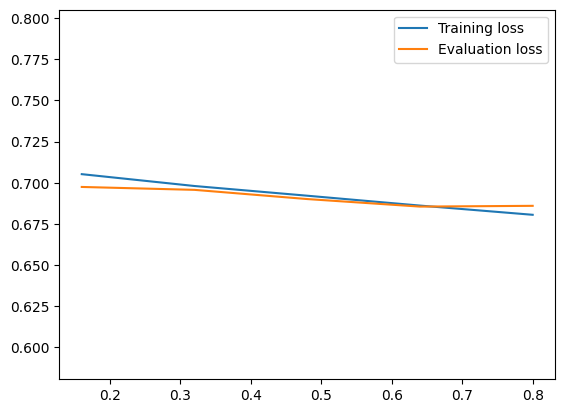

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

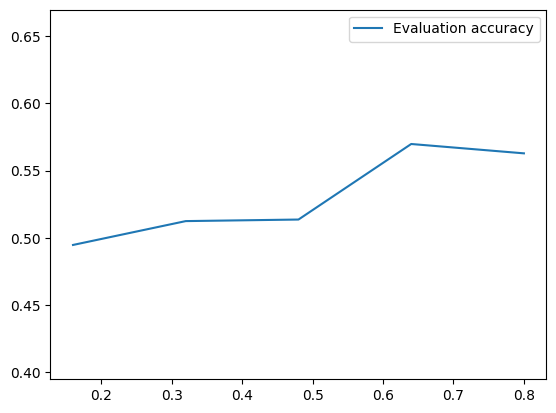

In [18]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])

The model has barely learned anything. What's going on? Can you improve on the performance e.g. by modifying the hyperparameters?